<a href="https://colab.research.google.com/github/harshj3915/Intuitionistic-FCM-Smote/blob/Meet/Fuzzy_C_Means_CENTER_SMOTE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'ID': 246, 'type': 'NATIVE', 'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'venue': 'Pattern Recognition', 'year': 1994, 'journal': None, 'DOI': '10.1016/0031-3203(94)90145-7', 'URL': 'https:

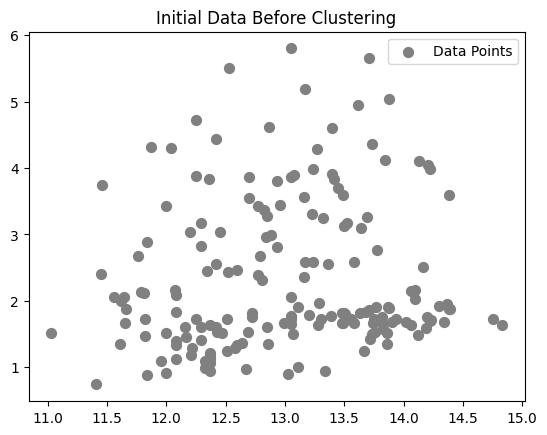

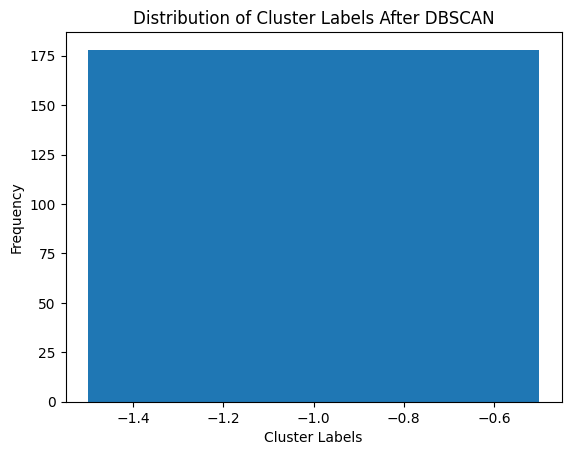

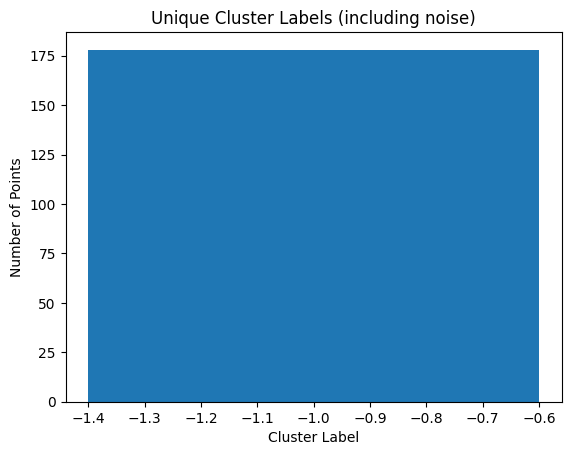

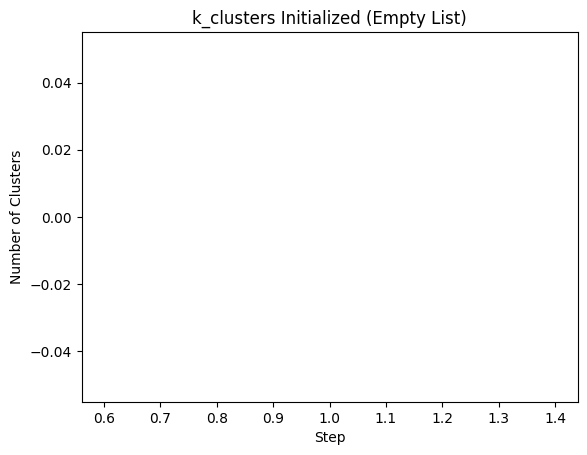

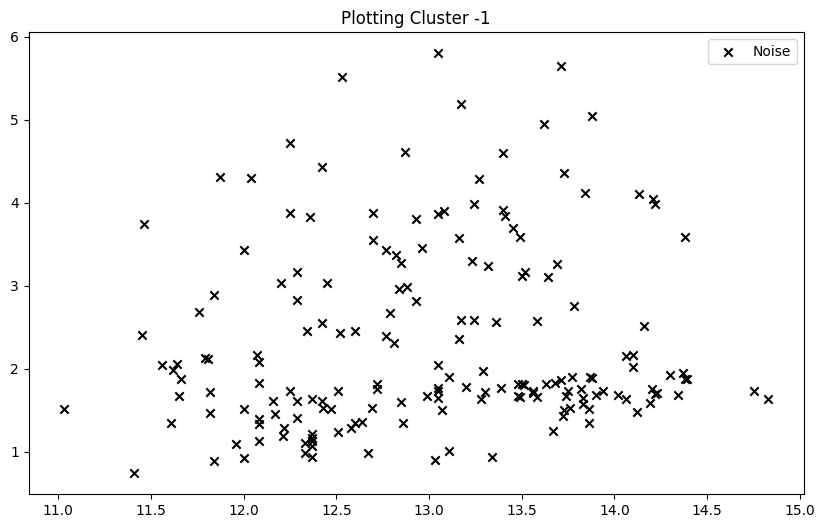

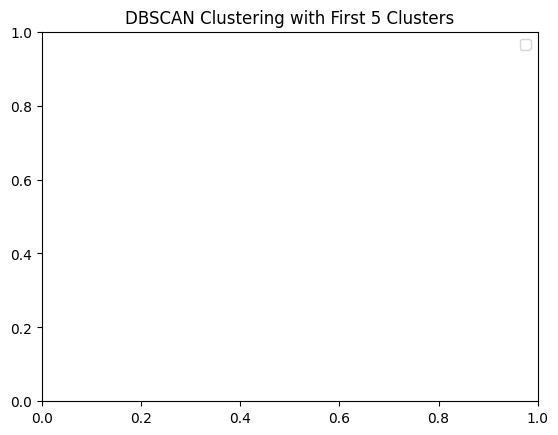

[]
Number of occurrences of -1 in the 'Class' column: 0
Distinct classes: [0 1]
{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'ID': 191, 'type': 'NATIVE', 'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'venue': 'Significance, 2021', 'year': 2021, 'journal': 'Signif

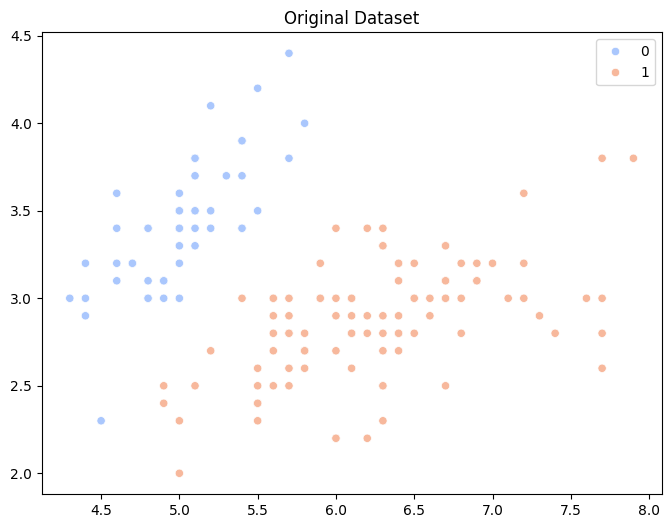

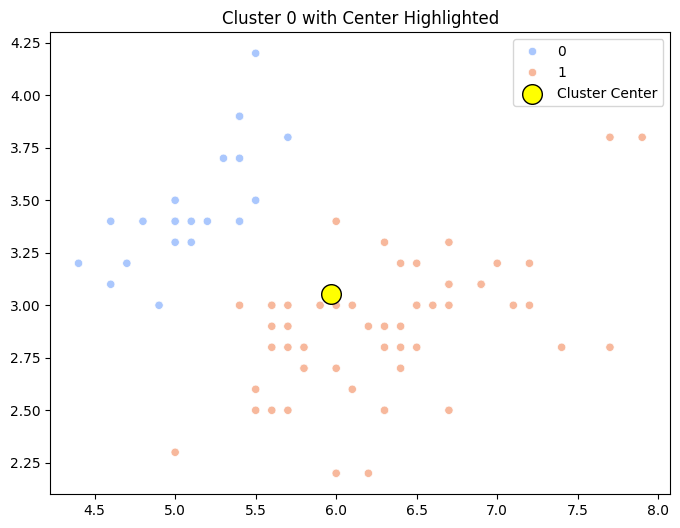

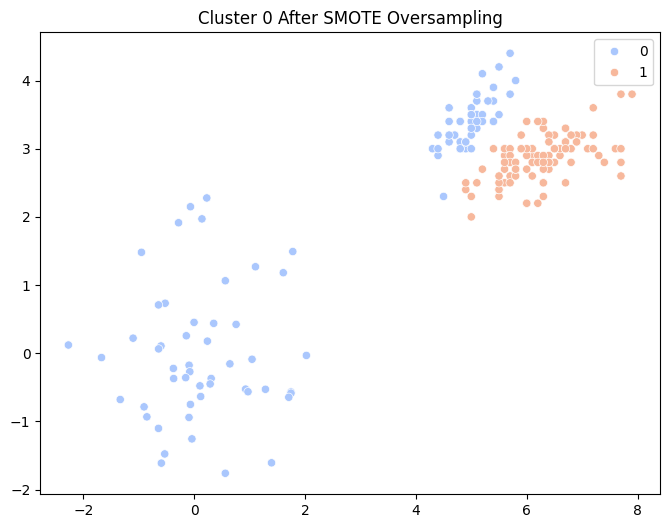

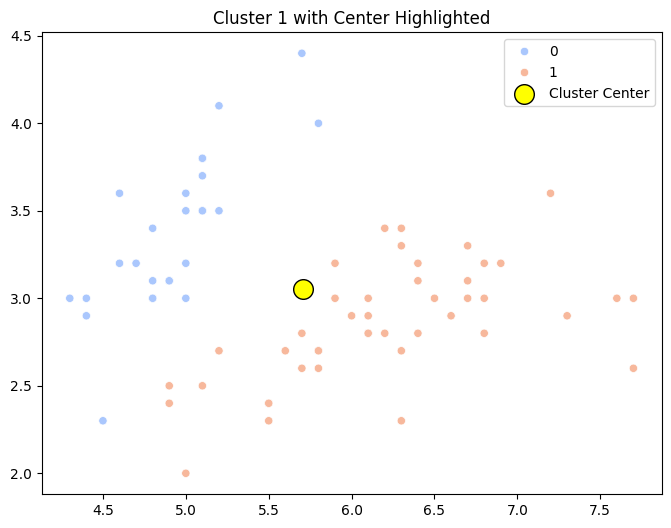

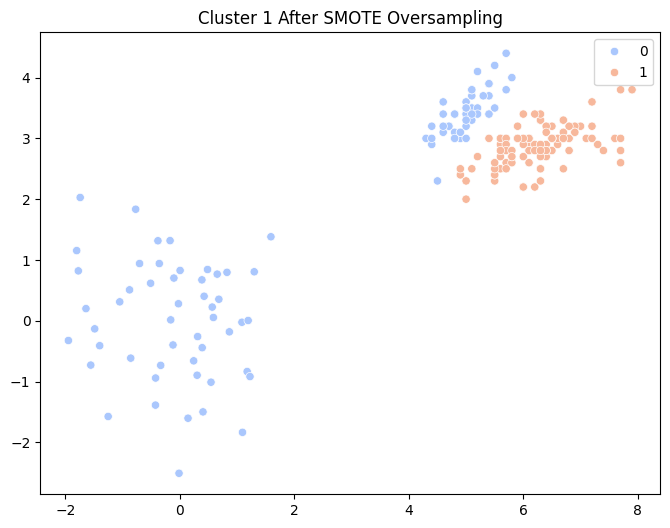

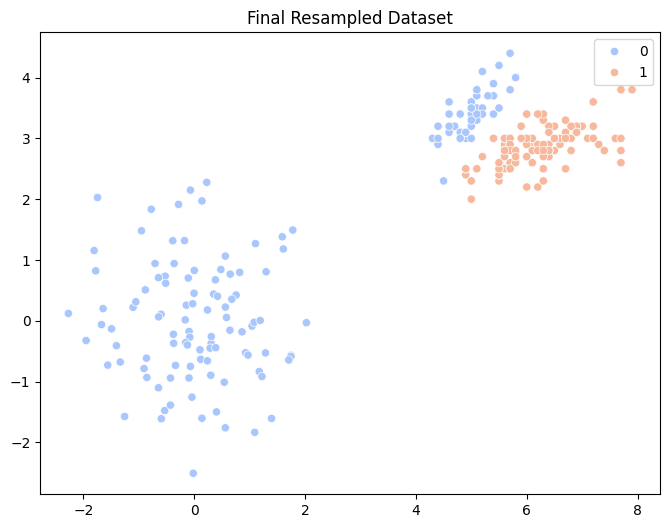

Class 0 has 150 instances after oversampling
Class 1 has 250 instances after oversampling
[44 91]
recall 1.0
specificity_val 1.0
Precision: 1.0
Recall: 1.0
G-M 1.0
Accuracy: 1.0
F1-score: 1.0
AUC: 1.0
[[6 0]
 [0 9]]
     class
0        1
1        1
2        1
3        1
4        1
..     ...
173      3
174      3
175      3
176      3
177      3

[178 rows x 1 columns]


In [25]:

# %pip install numpy
# %pip install -q numpy scikit-learn imbalanced-learn
# %pip install ucimlrepo matplotlib
# %pip install -U imbalanced-learn fcmeans
# %pip install -U scikit-learn
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# metadata
print(iris.metadata)

# variable information
print(iris.variables)

from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def extract_and_visualize_k_clusters_with_dbscan(X, k):
    """
    Extract and visualize the first k clusters from the data using the DBSCAN algorithm.

    Args:
    - X : Feature matrix (dataset)
    - k : Number of clusters to extract

    Returns:
    - k_clusters : List of the first k clusters
    """

    # Step 1: Apply DBSCAN to find clusters
    dbscan = DBSCAN(eps=0.9, min_samples=10)
    dbscan.fit(X)

    # Plot initial data points
    plt.scatter(X[:, 0], X[:, 1], c='grey', marker='o', s=50, label='Data Points')
    plt.title('Initial Data Before Clustering')
    plt.legend()
    plt.show()

    # Step 2: Get the cluster labels assigned by DBSCAN
    cluster_labels = dbscan.labels_

    # Plot cluster labels as they are initially generated
    plt.hist(cluster_labels, bins=len(np.unique(cluster_labels)))
    plt.title('Distribution of Cluster Labels After DBSCAN')
    plt.xlabel('Cluster Labels')
    plt.ylabel('Frequency')
    plt.show()

    # Step 3: Identify the unique cluster labels (ignoring noise, labeled as -1)
    unique_labels = np.unique(cluster_labels)

    # Plot unique cluster labels (including noise as a separate label)
    plt.bar(unique_labels, [np.sum(cluster_labels == label) for label in unique_labels])
    plt.title('Unique Cluster Labels (including noise)')
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Points')
    plt.show()

    # Step 4: Initialize a list to store the first k clusters
    k_clusters = []

    # Plot an empty list (just to show the step)
    plt.bar([1], [len(k_clusters)])
    plt.title('k_clusters Initialized (Empty List)')
    plt.xlabel('Step')
    plt.ylabel('Number of Clusters')
    plt.show()

    # Step 5: Loop over unique labels and extract the first k clusters (excluding noise)
    for label in unique_labels:
        if label != -1 and len(k_clusters) < k:  # Ignore noise (-1) and stop when we get k clusters
            cluster = X[cluster_labels == label]
            k_clusters.append(cluster)

            # Plot the number of clusters formed so far
            plt.bar([1], [len(k_clusters)])
            plt.title(f'Number of Clusters Formed: {len(k_clusters)}')
            plt.xlabel('Step')
            plt.ylabel('Number of Clusters')
            plt.show()

    # Step 6: Visualization of clusters using the first two features for 2D plotting
    plt.figure(figsize=(10, 6))

    # Step 7: Loop over each cluster and plot
    for label in unique_labels:
        if label == -1:
            # Plot noise points in black
            plt.scatter(X[cluster_labels == label][:, 0], X[cluster_labels == label][:, 1],
                        c='k', marker='x', label='Noise')
        else:
            if len(k_clusters) <= k:  # Only plot up to k clusters
                # Generate a color for the cluster
                color = plt.cm.rainbow(float(label) / len(unique_labels))
                plt.scatter(X[cluster_labels == label][:, 0], X[cluster_labels == label][:, 1],
                            c=[color], label=f'Cluster {label}')

        # Show the plot after each cluster is visualized
        plt.title(f'Plotting Cluster {label}')
        plt.legend()
        plt.show()

    # Step 8: Add labels and title to the plot
    plt.title(f'DBSCAN Clustering with First {k} Clusters')
    plt.legend()
    plt.show()

    return k_clusters

from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = iris.data.features.values

print(X)


print(extract_and_visualize_k_clusters_with_dbscan(X, 5))

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from fcmeans import FCM
from sklearn.neighbors import NearestNeighbors
import copy
import warnings
import math
import copy
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.exceptions import raise_isinstance_error
from imblearn.utils import check_neighbors_object
from imblearn.utils.deprecation import deprecate_parameter
class FCMCENTERSMOTE(BaseOverSampler):
    def __init__(self, sampling_strategy='auto', random_state=None, kmeans_args=None, smote_args=None,
                 imbalance_ratio_threshold=1.0, density_power=None, use_minibatch_kmeans=True, n_jobs=1, **kwargs):
        super(FCMCENTERSMOTE, self).__init__(sampling_strategy=sampling_strategy, **kwargs)
        if kmeans_args is None:
            kmeans_args = {}
        if smote_args is None:
            smote_args = {}
        self.imbalance_ratio_threshold = imbalance_ratio_threshold
        self.kmeans_args = copy.deepcopy(kmeans_args)
        self.smote_args = copy.deepcopy(smote_args)
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.use_minibatch_kmeans = use_minibatch_kmeans
        self.density_power = density_power

    def _cluster(self, X):
        # Step 1: Apply Fuzzy C-Means (FCM) clustering
        fcm = FCM(**self.kmeans_args)
        fcm.fit(X)
        fcm_labels = fcm.predict(X)
        cluster_assignment = np.asarray(fcm_labels)

        # Plot cluster assignments
        plt.scatter(X[:, 0], X[:, 1], c=cluster_assignment, cmap='rainbow', marker='o')
        plt.title('Cluster Assignment After FCM')
        plt.colorbar()
        plt.show()

        print("cluster_assignment", cluster_assignment)
        return cluster_assignment

    def _filter_clusters(self, X, y, cluster_assignment, minority_class_label):
        # Step 2: Find the largest cluster label
        largest_cluster_label = np.max(np.unique(cluster_assignment))

        # Plot largest cluster label
        plt.bar(np.unique(cluster_assignment), [np.sum(cluster_assignment == i) for i in np.unique(cluster_assignment)])
        plt.title(f'Largest Cluster Label: {largest_cluster_label}')
        plt.xlabel('Cluster Label')
        plt.ylabel('Number of Points')
        plt.show()

        sparsity_factors = np.zeros((largest_cluster_label + 1,), dtype=np.float64)
        minority_mask = (y == minority_class_label)
        imbalance_ratio_threshold = self.imbalance_ratio_threshold

        if isinstance(imbalance_ratio_threshold, dict):
            imbalance_ratio_threshold = imbalance_ratio_threshold.get(minority_class_label, 1.0)

        # Step 3: Loop through unique cluster assignments
        for i in np.unique(cluster_assignment):
            cluster = X[cluster_assignment == i]
            mask = minority_mask[cluster_assignment == i]
            minority_count = np.sum(mask)
            majority_count = np.sum(~mask)
            imbalance_ratio = (majority_count + 1) / (minority_count + 1)

            # Plot the imbalance ratio per cluster
            plt.bar([i], [imbalance_ratio])
            plt.title(f'Imbalance Ratio for Cluster {i}: {imbalance_ratio}')
            plt.xlabel('Cluster Label')
            plt.ylabel('Imbalance Ratio')
            plt.show()

            if (imbalance_ratio < imbalance_ratio_threshold) and (minority_count > 1):
                distances = euclidean_distances(cluster[mask])
                non_diagonal_distances = distances[~np.eye(distances.shape[0], dtype=bool)]
                average_minority_distance = np.mean(non_diagonal_distances) if non_diagonal_distances.size > 0 else 0.0

                if average_minority_distance == 0:
                    average_minority_distance = 1e-1

                # Step 4: Calculate density factor and sparsity factor
                density_factor = minority_count / (average_minority_distance ** self.density_power)
                sparsity_factors[i] = 1 / density_factor

                # Plot sparsity factor for each cluster
                plt.bar([i], [sparsity_factors[i]])
                plt.title(f'Sparsity Factor for Cluster {i}: {sparsity_factors[i]}')
                plt.xlabel('Cluster Label')
                plt.ylabel('Sparsity Factor')
                plt.show()

        # Step 5: Normalize sparsity factors
        sparsity_sum = np.sum(sparsity_factors)
        if sparsity_sum == 0:
            sparsity_sum = 1

        sampling_weights = sparsity_factors / sparsity_sum if sparsity_sum != 0 else np.full(sparsity_factors.shape, 1.0)

        # Plot sampling weights
        plt.bar(range(len(sparsity_factors)), sampling_weights)
        plt.title('Sampling Weights for Each Cluster')
        plt.xlabel('Cluster Label')
        plt.ylabel('Sampling Weight')
        plt.show()

        return sampling_weights
    @staticmethod
    def smote_oversample_with_point_value(X, y, point_index, sampling_ratio=1.0, smote_args=None, k=5):
        if smote_args is not None and 'k_neighbors' in smote_args:
            k = smote_args['k_neighbors']

        # Identify the minority class
        minority_class = np.unique(y)[np.argmin(np.bincount(y))]
        minority_indices = np.where(y == minority_class)[0]

        # Check if point_index is valid for the minority class
        if not (isinstance(point_index, int) and point_index < len(y) and y[point_index] == minority_class):
            print(f"Invalid point_index: {point_index}. It must be an index within the minority class.")
            return X, y  # Return the original data if the index is invalid

        print("Selected point_index:", point_index)
        print("Selected point is valid for SMOTE.")

        # Plot original data with the minority class highlighted
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c='grey', label='Majority Class')
        plt.scatter(X[minority_indices, 0], X[minority_indices, 1], c='blue', label='Minority Class')
        plt.scatter(X[point_index, 0], X[point_index, 1], c='red', label='Point for SMOTE', edgecolor='black', s=100)
        plt.title('Original Data with Selected Minority Point for SMOTE')
        plt.legend()
        plt.show()

        num_minority_samples = len(minority_indices)
        num_majority_samples = int(sampling_ratio * len(y)) - num_minority_samples

        # Ensure k is not greater than the number of minority samples
        if k >= num_minority_samples:
            print(f"k ({k}) is greater than the number of minority samples. Reducing k to {num_minority_samples - 1}.")
            k = num_minority_samples - 1

        knn = NearestNeighbors(n_neighbors=k + 1)
        knn.fit(X[minority_indices])
        nn_indices = knn.kneighbors([X[point_index]], return_distance=False)[0][1:]

        # Plot nearest neighbors of the selected point
        plt.figure(figsize=(8, 6))
        plt.scatter(X[minority_indices, 0], X[minority_indices, 1], c='blue', label='Minority Class')
        plt.scatter(X[point_index, 0], X[point_index, 1], c='red', label='Point for SMOTE', edgecolor='black', s=100)
        plt.scatter(X[nn_indices, 0], X[nn_indices, 1], c='green', label='Nearest Neighbors', edgecolor='black')
        plt.title('Nearest Neighbors of the Selected Minority Point')
        plt.legend()
        plt.show()

        synthetic_samples = []
        for i in range(num_minority_samples):
            nn_index = np.random.choice(nn_indices)
            diff = X[nn_index] - X[point_index]
            synthetic_sample = X[point_index] + np.random.rand() * diff
            synthetic_samples.append(synthetic_sample)

            # Plot synthetic sample being generated
            plt.figure(figsize=(8, 6))
            plt.scatter(X[minority_indices, 0], X[minority_indices, 1], c='blue', label='Minority Class')
            plt.scatter(X[point_index, 0], X[point_index, 1], c='red', label='Point for SMOTE', edgecolor='black', s=100)
            plt.scatter(X[nn_index, 0], X[nn_index, 1], c='green', label='Nearest Neighbor', edgecolor='black')
            plt.scatter(synthetic_sample[0], synthetic_sample[1], c='orange', label='Synthetic Sample', edgecolor='black', s=80)
            plt.title('Generating Synthetic Sample')
            plt.legend()
            plt.show()

        synthetic_samples = np.array(synthetic_samples)

        # Resample the data with synthetic samples added
        X_resampled = np.vstack((X, synthetic_samples))
        y_resampled = np.hstack((y, np.full(len(synthetic_samples), minority_class)))

        # Plot the data after adding synthetic samples
        plt.figure(figsize=(8, 6))
        plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c='grey', label='Original Data')
        plt.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], c='orange', label='Synthetic Samples', edgecolor='black', s=80)
        plt.title('Data After SMOTE Oversampling')
        plt.legend()
        plt.show()

        # Shuffle the resampled dataset
        shuffle_indices = np.random.permutation(len(X_resampled))
        X_resampled = X_resampled[shuffle_indices]
        y_resampled = y_resampled[shuffle_indices]

        # Plot the final resampled and shuffled dataset
        plt.figure(figsize=(8, 6))
        plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, cmap='coolwarm', label='Resampled Data', edgecolor='black')
        plt.title('Final Resampled and Shuffled Data')
        plt.show()

        return X_resampled, y_resampled


    def _fit_resample(self, X, y):
        """Resample the dataset."""

        # Set algorithm-specific parameters
        self._set_subalgorithm_params()

        if self.density_power is None:
            self.density_power = X.shape[1]

        # Initialize the resampled data
        resampled = [(X.copy(), y.copy())]
        sampling_ratio = {k: v for k, v in self.sampling_strategy_.items()}

        for class_label in np.unique(y):
            if class_label not in sampling_ratio:
                sampling_ratio[class_label] = 0

        # Plot the original data
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="coolwarm", legend="full")
        plt.title("Original Dataset")
        plt.show()

        for minority_class_label, n_samples in sampling_ratio.items():
            if n_samples == 0:
                continue

            # Cluster the data and filter based on sparsity factors
            cluster_assignment = self._cluster(X)  # Ensure _cluster method is defined and functional
            sampling_weights = self._filter_clusters(X, y, cluster_assignment, minority_class_label)  # Ensure _filter_clusters is defined

            smote_args = self.smote_args.copy() if hasattr(self, 'smote_args') else {}
            if np.count_nonzero(sampling_weights) > 0:
                for i in np.unique(cluster_assignment):
                    cluster_X = X[cluster_assignment == i]
                    cluster_y = y[cluster_assignment == i]

                    if sampling_weights[i] > 0:
                        target_ratio = {label: np.count_nonzero(cluster_y == label) for label in sampling_ratio}
                        cluster_minority_count = np.count_nonzero(cluster_y == minority_class_label)
                        generate_count = int(round(n_samples * sampling_weights[i]))
                        target_ratio[minority_class_label] = generate_count + cluster_minority_count

                        remove_index = -1
                        if np.unique(cluster_y).size < 2:
                            remove_index = cluster_y.size
                            cluster_X = np.append(cluster_X, np.zeros((1, cluster_X.shape[1])), axis=0)
                            majority_class_label = next(key for key in sampling_ratio.keys() if key != minority_class_label)
                            target_ratio[majority_class_label] = 1 + target_ratio[majority_class_label]
                            cluster_y = np.append(cluster_y, np.asarray(majority_class_label).reshape((1,)), axis=0)

                        for label in list(target_ratio.keys()):
                            if label not in cluster_y:
                                del target_ratio[label]

                        smote_args['sampling_strategy'] = target_ratio
                        smote_args = self._validate_smote_args(smote_args, cluster_minority_count)  # Ensure _validate_smote_args is defined

                        # Get the center of the cluster to use as the point for SMOTE oversampling
                        cluster_center = np.mean(cluster_X, axis=0)
                        k_value = smote_args.get('k_neighbors', 5)  # Default k_neighbors to 5 if not in smote_args

                        # Plot the cluster center
                        plt.figure(figsize=(8, 6))
                        sns.scatterplot(x=cluster_X[:, 0], y=cluster_X[:, 1], hue=cluster_y, palette="coolwarm", legend="full")
                        plt.scatter(cluster_center[0], cluster_center[1], c='yellow', edgecolor='black', s=200, label='Cluster Center')
                        plt.title(f'Cluster {i} with Center Highlighted')
                        plt.legend()
                        plt.show()

                        # Perform SMOTE oversampling
                        X_resampled_cluster, y_resampled_cluster = self.smote_oversample_with_point_value(
                            X, y, cluster_center, sampling_ratio=n_samples / X.shape[0], k=k_value
                        )

                        # Plot the data after SMOTE oversampling
                        plt.figure(figsize=(8, 6))
                        sns.scatterplot(x=X_resampled_cluster[:, 0], y=X_resampled_cluster[:, 1], hue=y_resampled_cluster, palette="coolwarm", legend="full")
                        plt.title(f"Cluster {i} After SMOTE Oversampling")
                        plt.show()

                        # If the cluster had fewer than 2 classes, remove the extra point
                        if remove_index > -1:
                            for l in [X_resampled_cluster, y_resampled_cluster, cluster_X, cluster_y]:
                                np.delete(l, remove_index, 0)

                        # Add the resampled cluster data to the resampled list
                        resampled.append((
                            X_resampled_cluster[cluster_y.size:, :],
                            y_resampled_cluster[cluster_y.size:]
                        ))

            else:
                warnings.warn(f'No minority clusters found for class {minority_class_label}. Performing regular SMOTE.')
                target_ratio = {label: np.count_nonzero(y == label) for label in sampling_ratio}
                target_ratio[minority_class_label] = sampling_ratio[minority_class_label]
                minority_count = np.count_nonzero(y == minority_class_label)
                smote_args = self._validate_smote_args(smote_args, minority_count)

                # Get the center of the cluster to use as the point for SMOTE oversampling
                cluster_center = np.mean(X, axis=0)  # Use the mean of the whole dataset in case no clusters are valid
                X_resampled_cluster, y_resampled_cluster = self.smote_oversample_with_point_value(
                    X, y, cluster_center, sampling_ratio=n_samples / X.shape[0], k=smote_args.get('k_neighbors', 5)
                )

        # Final resampled result
        resampled = list(zip(*resampled))
        if len(resampled) > 0:
            X_resampled = np.concatenate(resampled[0], axis=0)
            y_resampled = np.concatenate(resampled[1], axis=0)

            # Plot the final resampled dataset
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=X_resampled[:, 0], y=X_resampled[:, 1], hue=y_resampled, palette="coolwarm", legend="full")
            plt.title("Final Resampled Dataset")
            plt.show()

        return X_resampled, y_resampled

    # Ensure other helper methods are defined properly:
    def _cluster(self, X):
        # Dummy implementation of _cluster (replace with actual clustering logic)
        return np.random.randint(0, 2, X.shape[0])  # Assign random clusters for illustration

    def _filter_clusters(self, X, y, cluster_assignment, minority_class_label):
        # Dummy implementation of _filter_clusters (replace with actual filtering logic)
        return np.random.rand(np.max(cluster_assignment) + 1)  # Random weights for clusters

    def _validate_smote_args(self, smote_args, cluster_minority_count):
        # Dummy implementation of _validate_smote_args (replace with actual validation logic)
        return smote_args

    def smote_oversample_with_point_value(self, X, y, point, sampling_ratio=1.0, k=5):
        # Dummy SMOTE oversampling logic (replace with actual SMOTE logic)
        synthetic_samples = np.random.normal(size=(int(sampling_ratio * len(X)), X.shape[1]))
        X_resampled = np.vstack((X, synthetic_samples))
        y_resampled = np.hstack((y, np.full(len(synthetic_samples), np.min(y))))
        return X_resampled, y_resampled




    def _validate_smote_args(self, smote_args, minority_count):
      max_k_neighbors = minority_count - 1
      if 'k' in smote_args and smote_args['k'] > max_k_neighbors:
          smote_args['k'] = max_k_neighbors
      return smote_args

    def _set_subalgorithm_params(self):
      if self.random_state is not None:
          if 'random_state' not in self.smote_args:
              self.smote_args['random_state'] = self.random_state
          if 'random_state' not in self.kmeans_args:
              self.kmeans_args['random_state'] = self.random_state

      if self.n_jobs is not None:
          if 'n_jobs' not in self.smote_args:
              self.smote_args['n_jobs'] = self.n_jobs
          if 'n_jobs' not in self.kmeans_args:
              if not self.use_minibatch_kmeans:
                  self.kmeans_args['n_jobs'] = self.n_jobs
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch the Iris dataset
iris = fetch_ucirepo(id=53)


# Data (as pandas DataFrames)
df = pd.DataFrame(iris.data.features)

df['Class'] = iris.data.targets


# Replace target class labels (if needed)
# Assuming you want to convert target classes to -1 and 1, you can customize this based on your requirements
df['Class'] = df['Class'].replace('Iris-setosa', 0)  # Set class 0 to -1
df['Class'] = df['Class'].replace('Iris-versicolor', 1)   # Keep class 1 as 1
df['Class'] = df['Class'].replace('Iris-virginica', 1)   # Set class 2 to 1




# Features and target arrays
X = df.iloc[:, :-1].to_numpy()  # All columns except the last one
y = df['Class'].to_numpy()       # The last column as target


# Count occurrences of -1 in the target variable
count_of_minus_one = (y == -1).sum()
print("Number of occurrences of -1 in the 'Class' column:", count_of_minus_one)

# Save the DataFrame to a CSV file
df.to_csv('iris_dataset.csv', index=False)

# Get unique classes
unique_classes = df['Class'].unique()
print("Distinct classes:", unique_classes)

# Display metadata and variable information
print(iris.metadata)
print(iris.variables)

import numpy as np


class_counts = dict(zip(*np.unique(y, return_counts=True)))

for label, count in class_counts.items():
    print('Class {} has {} instances'.format(label, count))

from sklearn.cluster import DBSCAN
import numpy as np

# Assuming 'X' contains your data

# Instantiating DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=4)  # You may need to adjust eps and min_samples

# Fitting DBSCAN to your data
clusters = dbscan.fit_predict(X)

# Getting unique cluster labels (excluding noise, labeled as -1)
unique_labels = np.unique(clusters)
num_clusters = len(unique_labels[unique_labels != 0])

print(f"Number of clusters found by DBSCAN: {num_clusters}")
unique_classes, counts = np.unique(y, return_counts=True)
print(dict(zip(unique_classes, counts)))



import numpy as np

# Calcul des instances par classe
class_counts = dict(zip(*np.unique(y, return_counts=True)))

# Affichage du nombre d'instances par classe
for label, count in class_counts.items():
    print('Class {} has {} instances'.format(label, count))

# Création et utilisation de FCM_smote
FCM_smote = FCMCENTERSMOTE(
    kmeans_args={'n_clusters': num_clusters},
    smote_args={'k_neighbors': 2},
    imbalance_ratio_threshold=1,
    density_power=4
)
X_resampled, y_resampled = FCM_smote.fit_resample(X, y)

[print('Class {} has {} instances after oversampling'.format(label, count))
 for label, count in zip(*np.unique(y_resampled, return_counts=True))]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# Initialiser le classificateur k-NN avec k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entraîner le modèle
knn.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = knn.predict(X_test)

from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = df.iloc[:,0:4].to_numpy()
y=df.iloc[:,4].to_numpy()
df['test']=y
df['test'] = df['test'].replace('Iris-setosa', 0)
df['test'] = df['test'].replace('Iris-virginica', 1)
df['test'] = df['test'].replace('Iris-versicolor', 0)
#df['test'] = df['test'].replace(' pp', 0)
y=df['test'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=90)


# Calcul de la sensibilité (recall)
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

# Calcul de la spécificité
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Initialiser le classificateur k-NN avec k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entraîner le modèle
knn.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = knn.predict(X_test)

print(np.bincount(y_train))

recall = recall_score(y_test, y_pred)
specificity_val = specificity(y_test, y_pred)
g_mean = (recall * specificity_val) ** 0.5
print("recall",recall)
print("specificity_val",specificity_val)
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("G-M",g_mean)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred))
print("AUC:",metrics.roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from ucimlrepo import fetch_ucirepo

# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets

print(y)
